In [1]:
 from pathlib import Path
PATH_DATA = Path().resolve() / 'data'
PATH_DATA.mkdir(exist_ok=True)

In [2]:
!pip install simpletransformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 250 kB 12.6 MB/s 
     |████████████████████████████████| 5.3 MB 72.5 MB/s 
     |████████████████████████████████| 1.9 MB 59.7 MB/s 
     |████████████████████████████████| 9.2 MB 62.3 MB/s 
     |████████████████████████████████| 1.3 MB 64.3 MB/s 
     |████████████████████████████████| 43 kB 2.5 MB/s 
     |████████████████████████████████| 7.6 MB 61.6 MB/s 
     |████████████████████████████████| 441 kB 69.6 MB/s 
     |████████████████████████████████| 163 kB 69.5 MB/s 
     |████████████████████████████████| 182 kB 67.8 MB/s 
     |████████████████████████████████| 166 kB 69.3 MB/s 
     |████████████████████████████████| 63 kB 2.1 MB/s 
     |████████████████████████████████| 166 kB 76.4 MB/s 
     |████████████████████████████████| 162 kB 81.8 MB/s 
     |████████████████████████████████| 162 kB 74.5 MB/s 
     |█████████████████████████████

In [7]:
from simpletransformers.classification import ClassificationModel, ClassificationArgs

# Optional model configuration
model_args = ClassificationArgs()
model_args.num_train_epochs=1
model_args.overwrite_output_dir=True
model_args.learning_rate=2e-05

model = ClassificationModel("bert", "bert-base-uncased", args=model_args,use_cuda=True)
#model = ClassificationModel("bert", "diptanu/fBERT", args=model_args,use_cuda=True)
#model = ClassificationModel("bert", "GroNLP/hateBERT", args=model_args,use_cuda=True)

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [3]:
import pandas as pd
df_train_olid_small = pd.read_csv(PATH_DATA / 'df_train_olid_small_features.csv')
df_train_hasoc = pd.read_csv(PATH_DATA / 'df_train_hasoc_features.csv')
df_test_olid = pd.read_csv(PATH_DATA / 'df_test_olid_features.csv')

In [4]:
df_train_olid_small = df_train_olid_small[['id', 'clean_text', 'labels']]
df_train_hasoc = df_train_hasoc[['id', 'clean_text', 'labels']]
df_test_olid = df_test_olid[['id', 'clean_text', 'labels']]

df_train_olid_small.columns = ['id', 'text', 'labels']
df_train_hasoc.columns = ['id', 'text', 'labels']
df_test_olid.columns = ['id', 'text', 'labels']

In [8]:
model.train_model(df_train_olid_small)

  0%|          | 0/5852 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Running Epoch 0 of 1:   0%|          | 0/732 [00:00<?, ?it/s]

(732, 0.5242338441108745)

In [9]:
result, model_outputs, wrong_predictions = model.eval_model(df_test_olid)

  0%|          | 0/860 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/108 [00:00<?, ?it/s]

In [10]:
import numpy as np
import csv
import pandas as pd
df = pd.DataFrame(model_outputs)
df.to_csv('Bert_in_domain_outputs.csv', index=False, header=False)

In [11]:
y_pred=np.argmax(model_outputs, axis=1)
df2 = pd.DataFrame(y_pred)
df2.to_csv('Bert_in_domain_predictions.csv', index=False, header=False)

In [12]:
from sklearn.metrics import classification_report
import numpy as np

print(classification_report(
    y_true=df_test_olid['labels'],
    y_pred=np.argmax(model_outputs, axis=1)
))

              precision    recall  f1-score   support

           0       0.88      0.91      0.90       620
           1       0.75      0.67      0.71       240

    accuracy                           0.85       860
   macro avg       0.82      0.79      0.80       860
weighted avg       0.84      0.85      0.84       860



In [13]:
from sklearn.metrics import confusion_matrix

#Generate the confusion matrix
cf_matrix = confusion_matrix(df_test_olid['labels'],np.argmax(model_outputs, axis=1))

print(cf_matrix)

[[567  53]
 [ 79 161]]


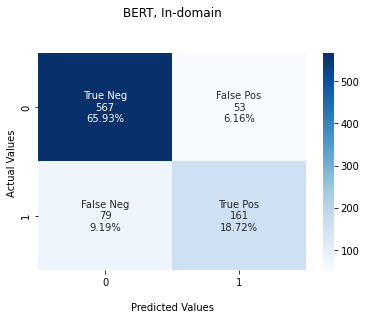

In [14]:
import seaborn as sns
import matplotlib.pyplot as plt

group_names = ['True Neg','False Pos','False Neg','True Pos']

group_counts = ["{0:0.0f}".format(value) for value in
                cf_matrix.flatten()]

group_percentages = ["{0:.2%}".format(value) for value in
                     cf_matrix.flatten()/np.sum(cf_matrix)]

labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]

labels = np.asarray(labels).reshape(2,2)

ax = sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')

ax.set_title('BERT, In-domain\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['0','1'])
ax.yaxis.set_ticklabels(['0','1'])

## Display the visualization of the Confusion Matrix.
plt.show()